<a href="https://colab.research.google.com/github/rfahrn/Shared_Task/blob/main/Shared_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
!git clone https://github.com/rfahrn/Shared_Task.git 

fatal: destination path 'Shared_Task' already exists and is not an empty directory.


In [ ]:
!ls

gdrive	sample_data  Shared_Task


In [37]:
import pandas as pd
train = pd.read_csv('Shared_Task/data/offenseval-ar-training-v1.tsv', sep='\t')

In [38]:
train.head(5)

,id,tweet,subtask_a
0,1,الحمدلله يارب فوز مهم يا زمالك.. كل الدعم ليكم...,NOT
1,2,فدوه يا بخت فدوه يا زمن واحد منكم يجيبه,NOT
2,3,RT @USER: يا رب يا واحد يا أحد بحق يوم الاحد ا...,OFF
3,4,RT @USER: #هوا_الحرية يا وجع قلبي عليكي يا امي...,NOT
4,5,يا بكون بحياتك الأهم يا إما ما بدي أكون 🎼,NOT


In [39]:
# !pip install emoji only install once
# !pip install DSAraby 
# !pip install Tashaphyne

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [40]:
# Preprocessing Arabic Tweets
import emoji

def avg_word(sentence):
    words = sentence.split()
    if len(words) == 0:
        return 0
    return (sum(len(word) for word in words)/len(words))

def emoji_counter(sentence):
    return emoji.emoji_count(sentence)


train['word_count'] = train['tweet'].apply(lambda x: len(str(x).split(" ")))
train['char_count'] = train['tweet'].str.len() ## this also includes spaces
train['avg_char_per_word'] = train['tweet'].apply(lambda x: avg_word(x))
stop = stopwords.words('arabic')
train['stopwords'] = train['tweet'].apply(lambda x: len([x for x in x.split() if x in stop]))
train['emoji_count'] = train['tweet'].apply(lambda x: emoji_counter(x))
train = train.sort_values(by='word_count',ascending=[0])
train.head()

,id,tweet,subtask_a,word_count,char_count,avg_char_per_word,stopwords,emoji_count
2922,2946,<LF>من المظاهر المؤسفه ان الاب والام <LF>يقعدو...,NOT,941,5857,4.403137,211,74
6062,6160,<LF>جده الحُب ،،<LF>جده يا مُنتهى كل الكلام يا...,NOT,862,5416,4.437751,203,36
4761,4833,"يا مالي عمري رضا يا شبيه الورد , يا معنى الحي...",NOT,531,3178,4.226974,147,108
6564,6707,يا من أظهر الجميل.. وستر القبيح.. يا من لا يؤا...,NOT,367,2283,4.397163,102,8
2753,2760,يا مُكعب السُكرَ يا زمُردي الأحمر و يأسريُ ال...,NOT,363,2129,4.165049,79,34


Text(0.5, 1.0, 'count NOT/OFF')

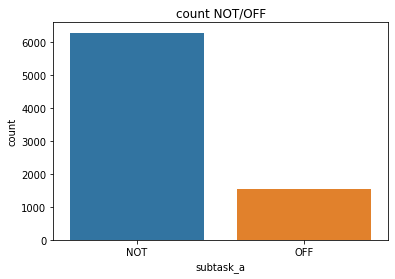

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(train.subtask_a)
plt.title('count NOT/OFF') # much mor not than offendent tweets

In [ ]:
# first we define a list of arabic and english punctiations that we want to get rid of in our text
import string
import re
punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ''' + string.punctuation

# Arabic stop words with nltk
stop_words = stopwords.words()
stops = set(stopwords.words("arabic"))
stop_word_comp = {"،","آض","آمينَ","آه","آهاً","آي","أ","أب","أجل","أجمع","أخ","أخذ","أصبح","أضحى","أقبل","أقل","أكثر","ألا","أم","أما","أمامك","أمامكَ","أمسى","أمّا","أن","أنا","أنت","أنتم","أنتما","أنتن","أنتِ","أنشأ","أنّى","أو","أوشك","أولئك","أولئكم","أولاء","أولالك","أوّهْ","أي","أيا","أين","أينما","أيّ","أَنَّ","أََيُّ","أُفٍّ","إذ","إذا","إذاً","إذما","إذن","إلى","إليكم","إليكما","إليكنّ","إليكَ","إلَيْكَ","إلّا","إمّا","إن","إنّما","إي","إياك","إياكم","إياكما","إياكن","إيانا","إياه","إياها","إياهم","إياهما","إياهن","إياي","إيهٍ","إِنَّ","ا","ابتدأ","اثر","اجل","احد","اخرى","اخلولق","اذا","اربعة","ارتدّ","استحال","اطار","اعادة","اعلنت","اف","اكثر","اكد","الألاء","الألى","الا","الاخيرة","الان","الاول","الاولى","التى","التي","الثاني","الثانية","الذاتي","الذى","الذي","الذين","السابق","الف","اللائي","اللاتي","اللتان","اللتيا","اللتين","اللذان","اللذين","اللواتي","الماضي","المقبل","الوقت","الى","اليوم","اما","امام","امس","ان","انبرى","انقلب","انه","انها","او","اول","اي","ايار","ايام","ايضا","ب","بات","باسم","بان","بخٍ","برس","بسبب","بسّ","بشكل","بضع","بطآن","بعد","بعض","بك","بكم","بكما","بكن","بل","بلى","بما","بماذا","بمن","بن","بنا","به","بها","بي","بيد","بين","بَسْ","بَلْهَ","بِئْسَ","تانِ","تانِك","تبدّل","تجاه","تحوّل","تلقاء","تلك","تلكم","تلكما","تم","تينك","تَيْنِ","تِه","تِي","ثلاثة","ثم","ثمّ","ثمّة","ثُمَّ","جعل","جلل","جميع","جير","حار","حاشا","حاليا","حاي","حتى","حرى","حسب","حم","حوالى","حول","حيث","حيثما","حين","حيَّ","حَبَّذَا","حَتَّى","حَذارِ","خلا","خلال","دون","دونك","ذا","ذات","ذاك","ذانك","ذانِ","ذلك","ذلكم","ذلكما","ذلكن","ذو","ذوا","ذواتا","ذواتي","ذيت","ذينك","ذَيْنِ","ذِه","ذِي","راح","رجع","رويدك","ريث","رُبَّ","زيارة","سبحان","سرعان","سنة","سنوات","سوف","سوى","سَاءَ","سَاءَمَا","شبه","شخصا","شرع","شَتَّانَ","صار","صباح","صفر","صهٍ","صهْ","ضد","ضمن","طاق","طالما","طفق","طَق","ظلّ","عاد","عام","عاما","عامة","عدا","عدة","عدد","عدم","عسى","عشر","عشرة","علق","على","عليك","عليه","عليها","علًّ","عن","عند","عندما","عوض","عين","عَدَسْ","عَمَّا","غدا","غير","ـ","ف","فان","فلان","فو","فى","في","فيم","فيما","فيه","فيها","قال","قام","قبل","قد","قطّ","قلما","قوة","كأنّما","كأين","كأيّ","كأيّن","كاد","كان","كانت","كذا","كذلك","كرب","كل","كلا","كلاهما","كلتا","كلم","كليكما","كليهما","كلّما","كلَّا","كم","كما","كي","كيت","كيف","كيفما","كَأَنَّ","كِخ","لئن","لا","لات","لاسيما","لدن","لدى","لعمر","لقاء","لك","لكم","لكما","لكن","لكنَّما","لكي","لكيلا","للامم","لم","لما","لمّا","لن","لنا","له","لها","لو","لوكالة","لولا","لوما","لي","لَسْتَ","لَسْتُ","لَسْتُم","لَسْتُمَا","لَسْتُنَّ","لَسْتِ","لَسْنَ","لَعَلَّ","لَكِنَّ","لَيْتَ","لَيْسَ","لَيْسَا","لَيْسَتَا","لَيْسَتْ","لَيْسُوا","لَِسْنَا","ما","ماانفك","مابرح","مادام","ماذا","مازال","مافتئ","مايو","متى","مثل","مذ","مساء","مع","معاذ","مقابل","مكانكم","مكانكما","مكانكنّ","مكانَك","مليار","مليون","مما","ممن","من","منذ","منها","مه","مهما","مَنْ","مِن","نحن","نحو","نعم","نفس","نفسه","نهاية","نَخْ","نِعِمّا","نِعْمَ","ها","هاؤم","هاكَ","هاهنا","هبّ","هذا","هذه","هكذا","هل","هلمَّ","هلّا","هم","هما","هن","هنا","هناك","هنالك","هو","هي","هيا","هيت","هيّا","هَؤلاء","هَاتانِ","هَاتَيْنِ","هَاتِه","هَاتِي","هَجْ","هَذا","هَذانِ","هَذَيْنِ","هَذِه","هَذِي","هَيْهَاتَ","و","و6","وا","واحد","واضاف","واضافت","واكد","وان","واهاً","واوضح","وراءَك","وفي","وقال","وقالت","وقد","وقف","وكان","وكانت","ولا","ولم","ومن","مَن","وهو","وهي","ويكأنّ","وَيْ","وُشْكَانََ","يكون","يمكن","يوم","ّأيّان"}

arabic_diacritics = re.compile("""
                             ّ    | # Shadda
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)

def preprocess(text):
    
    '''
    text is an arabic string input
    
    the preprocessed text is returned
    '''
    
    #remove punctuations
    translator = str.maketrans('', '', punctuations)
    text = text.translate(translator)
    
    # remove Tashkeel
    text = re.sub(arabic_diacritics, '', text)
    
    #remove longation
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)

    text = ' '.join(word for word in text.split() if word not in stop_words)

    return text
  
train['tweet'] = train['tweet'].apply(preprocess)
print(train.head(5))

        id                                              tweet subtask_a  \
2922  2946  LFمن المظاهر المءسفه ان الاب والام LFيقعدون يت...       NOT   
6062  6160  LFجده الحب LFجده منتهي الكلام سيده المدن ❤️ UR...       NOT   
4761  4833  مالي عمري رضا شبيه الورد معني الحياه♥️🖇 NOT 48...       NOT   
6564  6707  اظهر الجميل وستر القبيح يءاخذ بالجريره يهتك ال...       NOT   
2753  2760  مكعب السكر زمردي الاحمر ياسري الاكبر فتنتي الع...       NOT   

      word_count  char_count  avg_char_per_word  stopwords  emoji_count  
2922         941        5857           4.403137        211           74  
6062         862        5416           4.437751        203           36  
4761         531        3178           4.226974        147          108  
6564         367        2283           4.397163        102            8  
2753         363        2129           4.165049         79           34  


In [ ]:
train['tweet']

# hashtags in string 
#TODO


# emojis 
#TODO

In [34]:

from sklearn.model_selection import train_test_split
data = train
X = data.tweet.values
y = data.subtask_a.values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=2020)

